## Embeddings

In our previous example, we operated on high-dimensional bag-of-words vectors with length `vocab_size`, and we explicitly converted low-dimensional positional representation vectors into sparse one-hot representation. This one-hot representation is not memory-efficient. In addition, each word is treated independently from each other, so one-hot encoded vectors don't express semantic similarities between words.

In this unit, we will continue exploring the **News AG** dataset. To begin, let's load the data and get some definitions from the previous unit.

In [1]:
!pip install --user --quiet tensorflow-datasets wget protobuf==3.20

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np

# In this tutorial, we will be training a lot of models. In order to use GPU memory cautiously,
# we will set tensorflow option to grow GPU memory allocation when required.
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

ds_train, ds_test = tfds.load('ag_news_subset').values()


### What's an embedding?

The idea of **embedding** is to represent words using lower-dimensional dense vectors that reflect the semantic meaning of the word. We will later discuss how to build meaningful word embeddings, but for now let's just think of embeddings as a way to reduce the dimensionality of a word vector. 

So, an embedding layer takes a word as input, and produces an output vector of specified `embedding_size`. In a sense, it is very similar to a `Dense` layer, but instead of taking a one-hot encoded vector as input, it's able to take a word number.

By using an embedding layer as the first layer in our network, we can switch from bag-or-words to an **embedding bag** model, where we first convert each word in our text into the corresponding embedding, and then compute some aggregate function over all those embeddings, such as `sum`, `average` or `max`.  

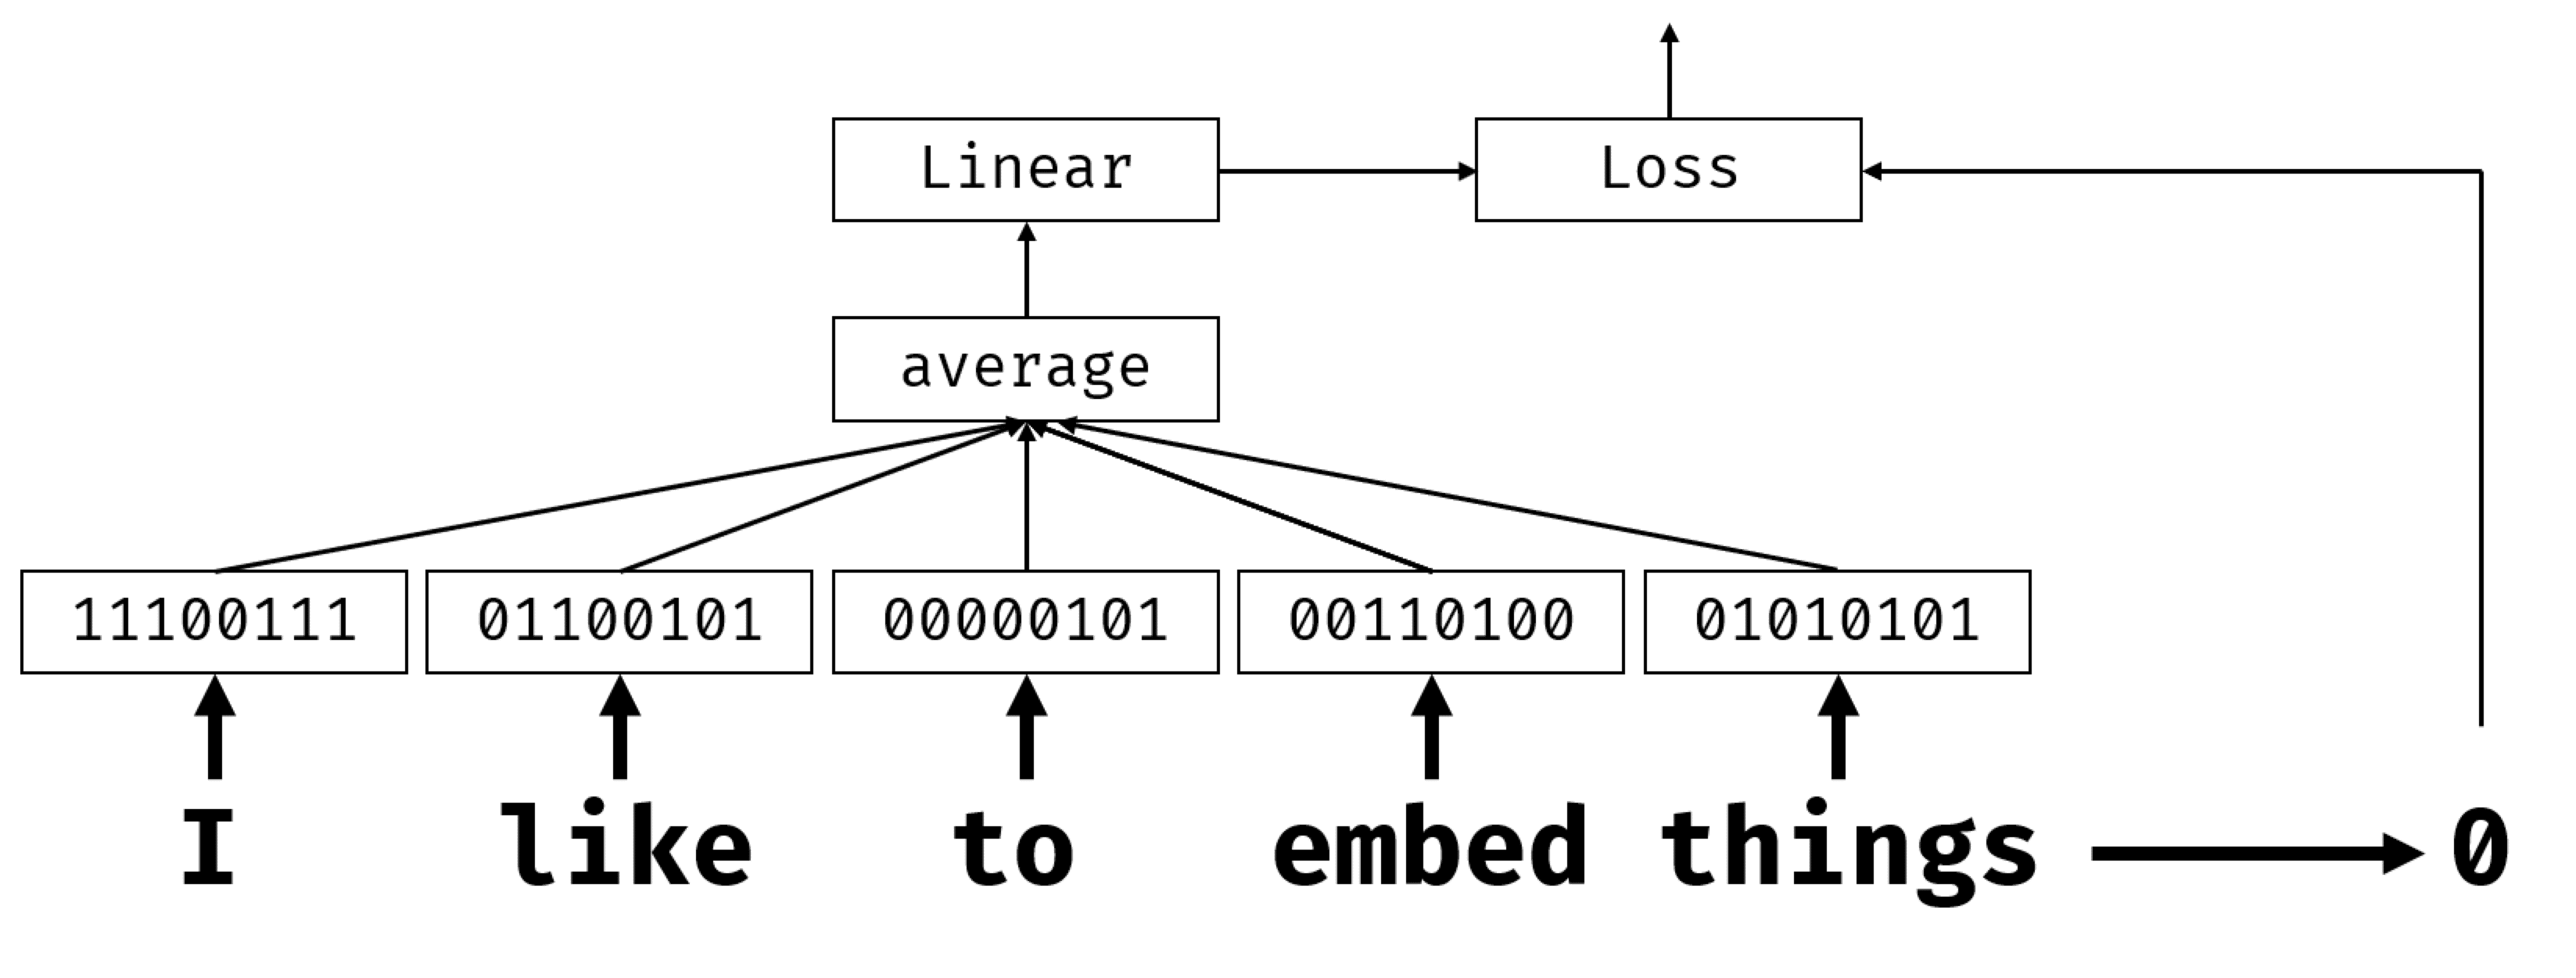

Our classifier neural network consists of the following layers:

* `TextVectorization` layer, which takes a string as input, and produces a tensor of token numbers. We will specify some reasonable vocabulary size `vocab_size`, and ignore less-frequently used words. The input shape will be 1, and the output shape will be $n$, since we'll get $n$ tokens as a result, each of them containing numbers from 0 to `vocab_size`.
* `Embedding` layer, which takes $n$ numbers, and reduces each number to a dense vector of a given length (100 in our example). Thus, the input tensor of shape $n$ will be transformed into an $n\times 100$ tensor. 
* Aggregation layer, which takes the average of this tensor along the first axis, i.e. it will compute the average of all $n$ input tensors corresponding to different words. To implement this layer, we will use a `Lambda` layer, and pass into it the function to compute the average. The output will have shape of 100, and it will be the numeric representation of the whole input sequence.
* Final `Dense` linear classifier.

In [3]:
vocab_size = 30000
batch_size = 128

vectorizer = keras.layers.experimental.preprocessing.TextVectorization(max_tokens=vocab_size,input_shape=(1,))

model = keras.models.Sequential([
    vectorizer,    
    keras.layers.Embedding(vocab_size,100),
    keras.layers.Lambda(lambda x: tf.reduce_mean(x,axis=1)),
    keras.layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 100)         3000000   
                                                                 
 lambda (Lambda)             (None, 100)               0         
                                                                 
 dense (Dense)               (None, 4)                 404       
                                                                 
Total params: 3,000,404
Trainable params: 3,000,404
Non-trainable params: 0
_________________________________________________________________


In the `summary` printout, in the **output shape** column, the first tensor dimension `None` corresponds to the minibatch size, and the second corresponds to the length of the token sequence. All token sequences in the minibatch have different lengths. We'll discuss how to deal with it in the next section.

Now let's train the network:

In [4]:
def extract_text(x):
    return x['title']+' '+x['description']

def tupelize(x):
    return (extract_text(x),x['label'])

print("Training vectorizer")
vectorizer.adapt(ds_train.take(500).map(extract_text))

model.compile(loss='sparse_categorical_crossentropy',metrics=['acc'])
model.fit(ds_train.map(tupelize).batch(batch_size),validation_data=ds_test.map(tupelize).batch(batch_size))

Training vectorizer
938/938 [==============================] - 15s 15ms/step - loss: 0.7972 - acc: 0.8094 - val_loss: 0.4522 - val_acc: 0.8663


> **Note** that we are building vectorizer based on a subset of the data. This is done in order to speed up the process, and it might result in a situation when not all tokens from our text is present in the vocabulary. In this case, those tokens would be ignored, which may result in slightly lower accuracy. However, in real life a subset of text often gives a good vocabulary estimation.

### Dealing with variable sequence sizes

Let's understand how training happens in minibatches. In the example above, the input tensor has dimension 1, and we use 128-long minibatches, so that actual size of the tensor is $128 \times 1$. However, the number of tokens in each sentence is different. If we apply the `TextVectorization` layer to a single input, the number of tokens returned is different, depending on how the text is tokenized:

In [5]:
print(vectorizer('Hello, world!'))
print(vectorizer('I am glad to meet you!'))

tf.Tensor([ 1 45], shape=(2,), dtype=int64)
tf.Tensor([ 112 1271    1    3 1747  158], shape=(6,), dtype=int64)


However, when we apply the vectorizer to several sequences, it has to produce a tensor of rectangular shape, so it fills unused elements with the PAD token (which in our case is zero):

In [6]:
vectorizer(['Hello, world!','I am glad to meet you!'])

<tf.Tensor: shape=(2, 6), dtype=int64, numpy=
array([[   1,   45,    0,    0,    0,    0],
       [ 112, 1271,    1,    3, 1747,  158]], dtype=int64)>

Here we can see the embeddings:

In [7]:
model.layers[1](vectorizer(['Hello, world!','I am glad to meet you!'])).numpy()

array([[[-5.5553898e-02,  5.1823754e-02,  5.1484287e-02, ...,
          4.2767912e-02,  8.7153517e-02, -3.9355412e-02],
        [-1.3957183e-01,  1.7420232e-01,  2.2543000e-01, ...,
          4.7962002e-02,  1.3605416e-01, -2.0630160e-01],
        [-2.4524909e-02, -4.2542517e-03, -2.1223614e-02, ...,
         -1.9121598e-02,  5.6725089e-02,  3.5925016e-02],
        [-2.4524909e-02, -4.2542517e-03, -2.1223614e-02, ...,
         -1.9121598e-02,  5.6725089e-02,  3.5925016e-02],
        [-2.4524909e-02, -4.2542517e-03, -2.1223614e-02, ...,
         -1.9121598e-02,  5.6725089e-02,  3.5925016e-02],
        [-2.4524909e-02, -4.2542517e-03, -2.1223614e-02, ...,
         -1.9121598e-02,  5.6725089e-02,  3.5925016e-02]],

       [[-1.0092192e-01,  1.2400236e-01,  7.0364863e-02, ...,
         -2.9492363e-02,  1.6877745e-01, -8.1137754e-02],
        [-8.6309128e-02, -1.4775261e-02, -4.2859767e-02, ...,
         -5.3992242e-02,  1.4989947e-01,  1.7871194e-02],
        [-5.5553898e-02,  5.1823754e-0

> **Note**: To minimize the amount of padding, in some cases it makes sense to sort all sequences in the dataset in the order of increasing length (or, more precisely, number of tokens). This will ensure that each minibatch contains sequences of similar length.


## Semantic embeddings: Word2Vec

In our previous example, the embedding layer learned to map words to vector representations, however, these representations did not have semantic meaning. It would be nice to learn a vector representation such that similar words or synonyms correspond to vectors that are close to each other in terms of some vector distance (for example euclidian distance).

To do that, we need to pretrain our embedding model on a large collection of text using a technique such as [Word2Vec](https://en.wikipedia.org/wiki/Word2vec). It's based on two main architectures that are used to produce a distributed representation of words:

 - **Continuous bag-of-words** (CBoW), where we train the model to predict a word from the surrounding context. Given the ngram $(W_{-2},W_{-1},W_0,W_1,W_2)$, the goal of the model is to predict $W_0$ from $(W_{-2},W_{-1},W_1,W_2)$.
 - **Continuous skip-gram** is the opposite of CBoW. The model uses the input word ($W_0$) to predict the surrounding window of context words.

CBoW is faster, and while skip-gram is slower, it does a better job of representing infrequent words.

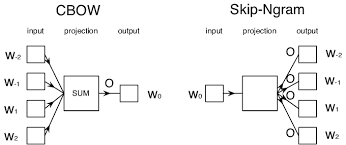

To experiment with the Word2Vec embedding pretrained on Google News dataset, we can use the **gensim** library. Below we find the words most similar to 'neural'.

> **Note:** When you first create word vectors, downloading them can take some time!

In [8]:
import gensim.downloader as api
w2v = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [9]:
for w,p in w2v.most_similar('neural'):
    print(f"{w} -> {p}")

neuronal -> 0.780479907989502
neurons -> 0.7326499223709106
neural_circuits -> 0.7252850532531738
neuron -> 0.7174385190010071
cortical -> 0.6941086649894714
brain_circuitry -> 0.6923245787620544
synaptic -> 0.6699119210243225
neural_circuitry -> 0.6638563275337219
neurochemical -> 0.6555314660072327
neuronal_activity -> 0.6531826853752136


We can also extract the vector embedding from the word, to be used in training the classification model. The embedding has 300 components, but here we only show the first 20 components of the vector for clarity:

In [10]:
w2v['play'][:20]

array([ 0.01226807,  0.06225586,  0.10693359,  0.05810547,  0.23828125,
        0.03686523,  0.05151367, -0.20703125,  0.01989746,  0.10058594,
       -0.03759766, -0.1015625 , -0.15820312, -0.08105469, -0.0390625 ,
       -0.05053711,  0.16015625,  0.2578125 ,  0.10058594, -0.25976562],
      dtype=float32)

The great thing about semantic embeddings is that you can manipulate the vector encoding based on semantics. For example, we can ask to find a word whose vector representation is as close as possible to the words *king* and *woman*, and as far as possible from the word *man*:

In [11]:
w2v.most_similar(positive=['king','woman'],negative=['man'])[0]

('queen', 0.7118193507194519)

An example above uses some internal GenSym magic, but the underlying logic is actually quite simple. An interesting thing about embeddings is that you can perform normal vector operations on embedding vectors, and that would reflect operations on word **meanings**. The example above can be expressed in terms of vector operations: we calculate the vector corresponding to **KING-MAN+WOMAN** (operations `+` and `-` are performed on vector representations of corresponding words), and then find the closest word in the dictionary to that vector:

In [12]:
# get the vector corresponding to kind-man+woman
qvec = w2v['king']-1.7*w2v['man']+1.7*w2v['woman']
# find the index of the closest embedding vector 
d = np.sum((w2v.vectors-qvec)**2,axis=1)
min_idx = np.argmin(d)
# find the corresponding word
w2v.index2word[min_idx]

AttributeError: The index2word attribute has been replaced by index_to_key since Gensim 4.0.0.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

> **NOTE**: We had to add a small coefficients to *man* and *woman* vectors - try removing them to see what happens.

To find the closest vector, we use TensorFlow machinery to compute a vector of distances between our vector and all vectors in the vocabulary, and then find the index of minimal word using `argmin`.

While Word2Vec seems like a great way to express word semantics, it has many disadvantages, including the following:

* Both CBoW and skip-gram models are **predictive embeddings**, and they only take local context into account. Word2Vec does not take advantage of global context.
* Word2Vec does not take into account word **morphology**, i.e. the fact that the meaning of the word can depend on different parts of the word, such as the root.  

**FastText** tries to overcome the second limitation, and builds on Word2Vec by learning vector representations for each word and the character n-grams found within each word. The values of the representations are then averaged into one vector at each training step. While this adds a lot of additional computation to pretraining, it enables word embeddings to encode sub-word information.

Another method, **GloVe**, uses a different approach to word embeddings, based on the factorization of the word-context matrix. First, it builds a large matrix that counts the number of word occurences in different contexts, and then it tries to represent this matrix in lower dimensions in a way that minimizes reconstruction loss.

The gensim library supports those word embeddings, and you can experiment with them by changing the model loading code above.

## Using pretrained embeddings in Keras

We can modify the example above to prepopulate the matrix in our embedding layer with semantic embeddings, such as Word2Vec. The vocabularies of the pretrained embedding and the text corpus will likely not match, so we need to choose one. Here we explore the two possible options: using the tokenizer vocabulary, and using the vocabulary from Word2Vec embeddings.

### Using tokenizer vocabulary

When using the tokenizer vocabulary, some of the words from the vocabulary will have corresponding Word2Vec embeddings, and some will be missing. Given that our vocabulary size is `vocab_size`, and the Word2Vec embedding vector length is `embed_size`, the embedding layer will be repesented by a weight matrix of shape `vocab_size`$\times$`embed_size`. We will populate this matrix by going through the vocabulary:

In [ ]:
embed_size = len(w2v.get_vector('hello'))
print(f'Embedding size: {embed_size}')

vocab = vectorizer.get_vocabulary()
W = np.zeros((vocab_size,embed_size))
print('Populating matrix, this will take some time...',end='')
found, not_found = 0,0
for i,w in enumerate(vocab):
    try:
        W[i] = w2v.get_vector(w)
        found+=1
    except:
        # W[i] = np.random.normal(0.0,0.3,size=(embed_size,))
        not_found+=1

print(f"Done, found {found} words, {not_found} words missing")

For words that are not present in the Word2Vec vocabulary, we can either leave them as zeroes, or generate a random vector.

Now we can define an embedding layer with pretrained weights:

In [ ]:
emb = keras.layers.Embedding(vocab_size,embed_size,weights=[W],trainable=False)
model = keras.models.Sequential([
    vectorizer, emb,
    keras.layers.Lambda(lambda x: tf.reduce_mean(x,axis=1)),
    keras.layers.Dense(4, activation='softmax')
])

Now let's train our model. 

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',metrics=['acc'])
model.fit(ds_train.map(tupelize).batch(batch_size),
          validation_data=ds_test.map(tupelize).batch(batch_size))

> **Note**: Notice that we set `trainable=False` when creating the `Embedding`, which means that we're not retraining the Embedding layer. This may cause accuracy to be slightly lower, but it speeds up the training.

### Using embedding vocabulary

One issue with the previous approach is that the vocabularies used in the TextVectorization and Embedding are different. To overcome this problem, we can use one of the following solutions:
* Re-train the Word2Vec model on our vocabulary.
* Load our dataset with the vocabulary from the pretrained Word2Vec model. Vocabularies used to load the dataset can be specified during loading.

The latter approach seems easier, so let's implement it. First of all, we will create a `TextVectorization` layer with the specified vocabulary, taken from the Word2Vec embeddings:

In [ ]:
vocab = list(w2v.vocab.keys())
vectorizer = keras.layers.experimental.preprocessing.TextVectorization(input_shape=(1,))
vectorizer.set_vocabulary(vocab)

The gensim word embeddings library contains a convenient function, `get_keras_embeddings`, which will automatically create the corresponding Keras embeddings layer for you.

In [ ]:
model = keras.models.Sequential([
    vectorizer, 
    w2v.get_keras_embedding(train_embeddings=False),
    keras.layers.Lambda(lambda x: tf.reduce_mean(x,axis=1)),
    keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',metrics=['acc'])
model.fit(ds_train.map(tupelize).batch(128),validation_data=ds_test.map(tupelize).batch(128),epochs=5)

One of the reasons we're not seeing higher accuracy is because some words from our dataset are missing in the pretrained GloVe vocabulary, and thus they are essentially ignored. To overcome this, we can train our own embeddings based on our dataset. 


## Training your own embeddings

In our examples, we have been using pretrained semantic embeddings, but it is interesting to see how those embeddings can be trained using either CBoW, or skip-gram architectures. This exercise goes beyond this module, but those interested might want to check out this [official TensorFlow tutorial on training Word2Vec model](https://www.tensorflow.org/tutorials/text/word2vec). Also, the **gensim** framework can be used to train the most commonly used embeddings in a few lines of code, as described [in the official documentation](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#training-your-own-model).

## Contextual embeddings

One key limitation of traditional pretrained embedding representations such as Word2Vec is the fact that, even though they can capture some meaning of a word, they can't differentiate between different meanings. This can cause problems in downstream models.

For example the word 'play' has different meaning in these two different sentences:
- I went to a **play** at the theater.
- John wants to **play** with his friends.

The pretrained embeddings we talked about represent both meanings of the word 'play' in the same embedding. To overcome this limitation, we need to build embeddings based on the **language model**, which is trained on a large corpus of text, and *knows* how words can be put together in different contexts. Discussing contextual embeddings is out of scope for this tutorial, but we will come back to them when talking about language models in the next unit.
